## EfficientNetB0 Overview

EfficientNetB0 is the baseline model of the EfficientNet family introduced by **Google**.  
It is designed to achieve **high accuracy** with **fewer parameters** and **lower computational cost** compared to previous CNN architectures.

### 🔍 Key Concepts
- **Compound Scaling**: EfficientNet uses a unique scaling method that **uniformly scales** depth, width, and resolution using fixed coefficients.
- **Pre-trained on ImageNet**: Makes it great for **transfer learning** in tasks like medical image classification.
- **Lightweight & Powerful**: Offers an excellent trade-off between performance and model size.

### ✅ Benefits
- High accuracy with fewer FLOPs.
- Faster training and inference.
- Ideal for deployment on edge/mobile devices.



##  Dataset Overview

This project utilizes the **COVID-19 Radiography Database**, which contains chest X-ray images categorized into **four distinct classes**:

- 📁 `Normal`: Healthy chest X-rays.
- 📁 `Lung_Opacity`: X-rays showing signs of lung opacity (often linked to pneumonia or other abnormalities).
- 📁 `Viral Pneumonia`: X-rays labeled with viral pneumonia infections.
- 📁 `COVID`: X-rays of patients diagnosed with COVID-19.






## 📚 Library Imports

This section includes all necessary libraries for data handling, visualization, image processing, model building, and evaluation.


In [ ]:
import os
from pathlib import Path
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

## 🗂️ Explore Dataset Structure

Before working with the images, we walk through the dataset directory to understand its internal folder structure.
This is helpful for verifying the presence of image files and understanding how the data is organized.


In [ ]:
for dirname,subdirs,filenames in os.walk('/kaggle/input/'):
    print(f'Directory:{dirname}')
    for subdir in subdirs:
        print(f'  subdircotry:{subdir}')
    #for filename in filenames:
     #   print(f'  subdircotry:{filename}')

Directory:/kaggle/input/
  subdircotry:covid19-radiography-database
Directory:/kaggle/input/covid19-radiography-database
  subdircotry:COVID-19_Radiography_Dataset
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
  subdircotry:Normal
  subdircotry:Lung_Opacity
  subdircotry:Viral Pneumonia
  subdircotry:COVID
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
  subdircotry:images
  subdircotry:masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity
  subdircotry:images
  subdircotry:masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/ma

## 🧮 Image Count per Class

To understand the class distribution in the dataset, we count how many images are available for each category.
This helps us detect any class imbalance that might affect model training.


In [ ]:
from pathlib import Path

n = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images")
l = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images")
v = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images")
c = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images")

image_dirs = {
    "Normal": n,
    "Lung Opacity": l,
    "Viral Pneumonia": v,
    "COVID": c
}

for label, image_dir in image_dirs.items():
    if image_dir.exists():
        file_count = len(list(image_dir.glob('*')))  # Count the number of files
        print(f"{file_count} for {label}")


10192 for Normal
6012 for Lung Opacity
1345 for Viral Pneumonia
3616 for COVID


## 🗃️ Organizing Images by Class

To streamline data loading and preprocessing, we organize all images into a single directory with subfolders for each class.
This is useful for tools like `ImageDataGenerator` or `tf.keras.uti


In [ ]:
# Define paths for each class
n = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images")
l = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images")
v = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images")
c = Path("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images")

# Define the target directory to store the organized images
target_dir = "/kaggle/working/organized_data"

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Function to organize images by class
def organize_images(source_dir, class_name):
    class_dir = os.path.join(target_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for file in source_dir.glob("*"):
        shutil.copy(file, class_dir)

# Organize images for each class
organize_images(n, 'Normal')
organize_images(l, 'Lung_Opacity')
organize_images(v, 'Viral_Pneumonia')
organize_images(c, 'COVID')



## 🧾 Dataset Creation & Splitting

We load the dataset directly from the organized folder structure using TensorFlow's `image_dataset_from_directory`.  
Then we split it into training (70%), validation (20%), and test (10%) sets.  
This ensures a balanced and reproducible training pipeline.


In [ ]:
# Define the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    target_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=42
)


# calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.2 * dataset_size)    # 20% for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing

# split the dataset
train_dataset = dataset.take(train_size)  # Take the first 70%
remaining = dataset.skip(train_size)      # Skip the first 70%
val_dataset = remaining.take(val_size)    # Take the next 20%
test_dataset = remaining.skip(val_size)   # The remaining 10%

train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache()

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")


Found 21165 files belonging to 4 classes.
Training batches: 231
Validation batches: 66
Test batches: 34


## 🖼️ Preview a Batch of Images and Labels

We inspect one batch from the training set to verify the input shape and corresponding class labels.
This is useful for confirming image dimensions and label integrity before feeding data into the model.


In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape)  # (batch_size, image_height, image_width, channels)
    print(labels.numpy())  # (batch_size,)


(64, 224, 224, 3)
[2 2 1 2 1 2 2 1 2 2 2 2 1 2 2 2 2 0 1 2 2 2 2 1 1 1 0 0 0 2 0 2 1 2 2 1 1
 0 0 0 2 2 2 1 0 2 0 1 0 1 0 2 0 3 1 2 2 0 1 2 1 0 0 2]


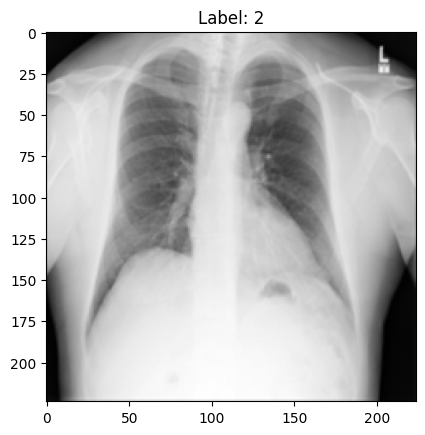

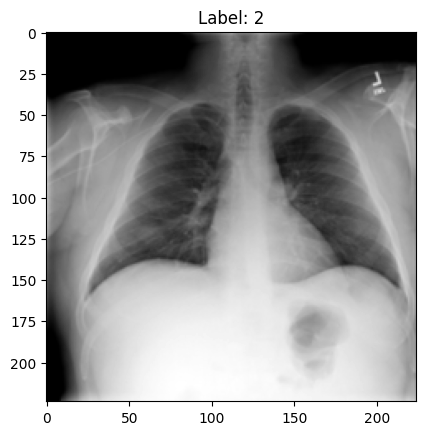

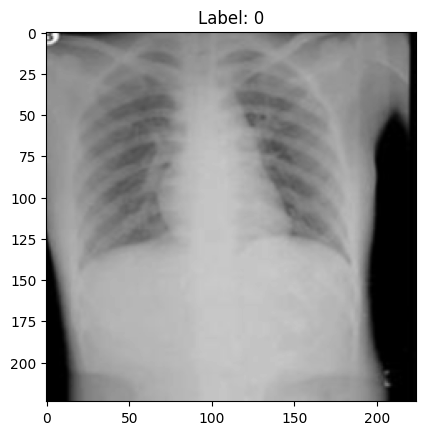

In [ ]:
for img, label in train_dataset.unbatch().take(3):
    img_gray = tf.image.rgb_to_grayscale(img)  # Convert to grayscale
    img_gray = img_gray.numpy()
    plt.imshow(img_gray.squeeze(), cmap="gray")
    plt.title(f"Label: {label.numpy()}")
    plt.show()

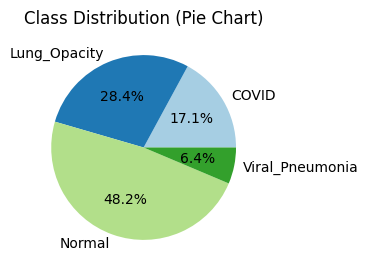

In [ ]:
class_names = dataset.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in dataset.unbatch():
    label = labels.numpy()
    class_counts[class_names[label]] += 1

plt.figure(figsize=(3, 3))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Class Distribution (Pie Chart)")
plt.show()


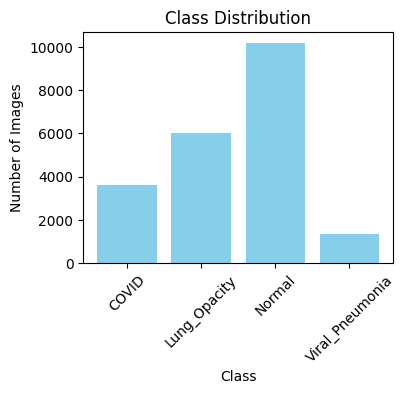

In [ ]:
class_names = dataset.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in dataset.unbatch():
    label = labels.numpy()
    class_counts[class_names[label]] += 1

plt.figure(figsize=(4, 3))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


## 🚀 Build Transfer Learning Model with EfficientNetB0

- Load EfficientNetB0 pretrained on ImageNet without the top classification layer (`include_top=False`).
- Freeze the base model to keep pretrained weights intact.
- Add BatchNormalization, Dense layers with L2 regularization, Dropout for regularization, and a final Dense layer with softmax for 4-class classification.
- Compile the model with Adamax optimizer and sparse categorical crossentropy loss.


In [ ]:
# Load EfficientNet base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'  # Use global max pooling
)

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

## 🏁 Model Training with Callbacks

Training the EfficientNet-based model with:

- **EarlyStopping** to prevent overfitting by stopping early.
- **ReduceLROnPlateau** to adjust learning rate dynamically for better convergence.
- **ModelCheckpoint** to save the best model weights during training.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('efficientnet_best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1010s 59ms/step - accuracy: 0.7138 - loss: 4.7668 - val_accuracy: 0.8712 - val_loss: 3.1948 - learning_rate: 0.0010

Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1010s 59ms/step - accuracy: 0.8428 - loss: 3.0290 - val_accuracy: 0.8930 - val_loss: 2.2156 - learning_rate: 0.0010

Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1005s 59ms/step - accuracy: 0.8647 - loss: 2.1083 - val_accuracy: 0.8982 - val_loss: 1.5889 - learning_rate: 0.0010

Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1005s 59ms/step - accuracy: 0.8837 - loss: 1.5166 - val_accuracy: 0.9046 - val_loss: 1.1898 - learning_rate: 0.0010

Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1005s 59ms/step - accuracy: 0.8965 - loss: 1.1418 - val_accuracy: 0.8982 - val_loss: 0.9543 - learning_rate: 0.0010

Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1010s 59ms/step - accuracy: 0.9008 - loss: 0.8986 - val_accuracy: 0.9079 - val_loss: 0.7778 - learning_rate: 0.0010

Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1005s 59ms/step - 

## Comprehensive Model Evaluation Across Training, Validation, and Test Data


In [ ]:

train_score = model.evaluate(train_dataset,verbose= 1)
valid_score = model.evaluate(val_dataset,verbose= 1)
test_score = model.evaluate(test_dataset,verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Evaluating on training data...
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 45ms/step - accuracy: 0.9754 - loss: 0.2343
Train Loss:  0.2345820963382721
Train Accuracy:  0.9752435088157654
--------------------
Evaluating on validation data...
66/66 ━━━━━━━━━━━━━━━━━━━━ 503s 44ms/step - accuracy: 0.9207 - loss: 0.3708
Validation Loss:  0.38798072934150696
Validation Accuracy:  0.9133522510528564
--------------------
Evaluating on test data...
34/34 ━━━━━━━━━━━━━━━━━━━━ 230s 43ms/step - accuracy: 0.9124 - loss: 0.4100
Test Loss:  0.4229409694671631
Test Accuracy:  0.9086694717407227


# Added augmentation layers


To enhance the diversity of training data and improve the model's generalization, we apply **data augmentation** using TensorFlow's preprocessing layers.



In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Using EfficientNetB0 with unfreeze last 20 layers

In [ ]:
# Load EfficientNet base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'
)

base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 1,461,812 (5.58 MB)

 Non-trainable params: 2,922,867 (11.15 MB)

## 🏁 Model Training with Callbacks

Training the EfficientNet-based model with:

- **EarlyStopping** to prevent overfitting by stopping early.
- **ReduceLROnPlateau** to adjust learning rate dynamically for better convergence.
- **ModelCheckpoint** to save the best model weights during training.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('efficientnet_best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1005s 705ms/step - accuracy: 0.6491 - loss: 8.3255 - val_accuracy: 0.8461 - val_loss: 4.6372 - learning_rate: 0.001
Epoch 2/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 705ms/step - accuracy: 0.8206 - loss: 4.1154 - val_accuracy: 0.8627 - val_loss: 2.5321 - learning_rate: 0.001
Epoch 3/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 705ms/step - accuracy: 0.8501 - loss: 2.2873 - val_accuracy: 0.8738 - val_loss: 1.4755 - learning_rate: 0.001
Epoch 4/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 705ms/step - accuracy: 0.8622 - loss: 1.3610 - val_accuracy: 0.8693 - val_loss: 0.9740 - learning_rate: 0.001
Epoch 5/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1030s 705ms/step - accuracy: 0.8765 - loss: 0.9045 - val_accuracy: 0.8944 - val_loss: 0.6638 - learning_rate: 0.001
Epoch 6/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 705ms/step - accuracy: 0.8829 - loss: 0.6487 - val_accuracy: 0.8999 - val_loss: 0.5107 - learning_rate: 0.001
Epoch 7/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 1000s 705ms/step - accur

# Evaluate model 2

In [ ]:
train_score = model.evaluate(train_dataset,verbose= 1)
valid_score = model.evaluate(val_dataset,verbose= 1)
test_score = model.evaluate(test_dataset,verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

231/231 ━━━━━━━━━━━━━━━━━━━━ 1030s 693ms/step - accuracy: 0.9664 - loss: 0.1248
66/66 ━━━━━━━━━━━━━━━━━━━━ 730s 45ms/step - accuracy: 0.9269 - loss: 0.2241
34/34 ━━━━━━━━━━━━━━━━━━━━ 400s 215ms/step - accuracy: 0.9151 - loss: 0.2592
Train Loss:  0.12539458274841309
Train Accuracy:  0.9656385183334351
--------------------
Validation Loss:  0.2219717651605606
Validation Accuracy:  0.9339488744735718
--------------------
Test Loss:  0.2690165638923645
Test Accuracy:  0.9137691259384155


## Training & Validation Performance Over Epochs

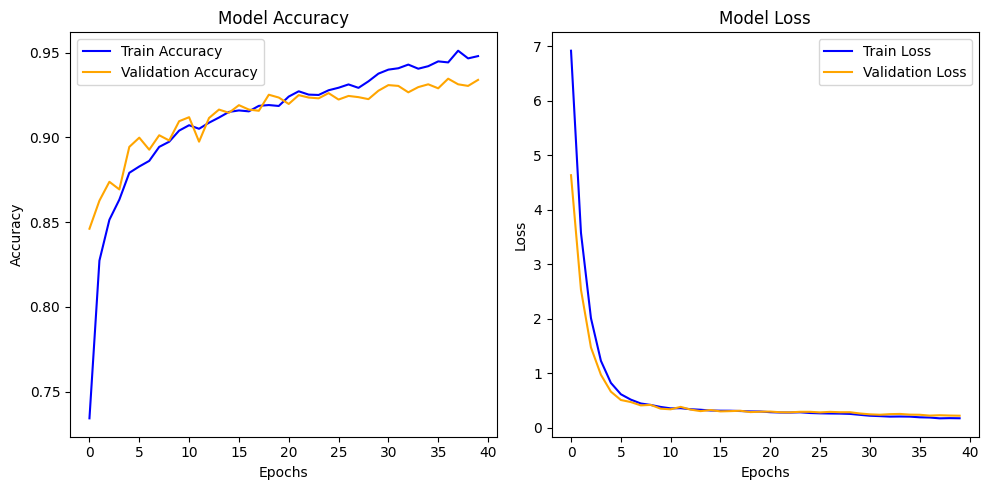

In [ ]:
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Classification Report

In [ ]:
y_pred_probs = model.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       367
           1       0.89      0.88      0.89       629
           2       0.92      0.93      0.92      1005
           3       0.96      0.95      0.95       156

    accuracy                           0.91      2157
   macro avg       0.92      0.92      0.92      2157
weighted avg       0.91      0.91      0.91      2157



# Confusion Matrics

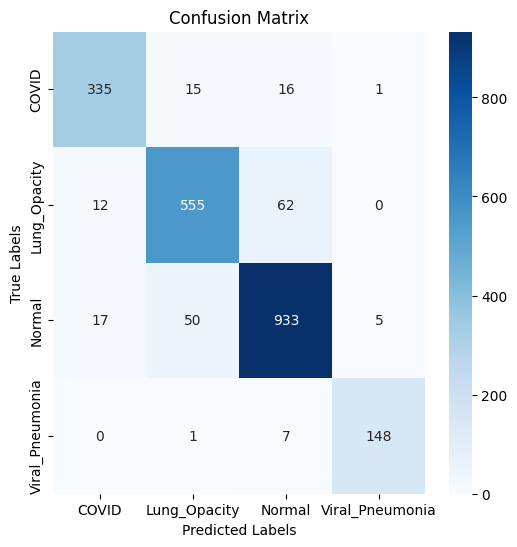

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Get Predictions

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


array([2, 2, 1, ..., 2, 3, 2], dtype=int32)

 ## 🔥 EfficientNet Model

In [ ]:
subject = 'Covid-19'
model_name = 'efficientnet'
acc = test_score[1] * 100

# Define the save path
save_path = '/kaggle/working'

# Save the entire model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.keras')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save only the weights (with the correct filename format)
weight_save_id = str(f'{model_name}-{subject}-weights.weights.h5')  # Use .weights.h5
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')

Model was saved as /kaggle/working/efficientnet-Covid-19-91.38.keras
Weights were saved as /kaggle/working/efficientnet-Covid-19-weights.weights.h5
